<a href="https://colab.research.google.com/github/Jiacheng1216/Tensorflow2.0/blob/master/LAB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
summary_writer = tf.summary.create_file_writer('lab7-logs-summary')

In [ ]:
x = np.linspace(0, 2 * np.pi , 100)
data = np.sin(x)
with summary_writer.as_default(): 
    for i, y in enumerate(data):
        tf.summary.scalar('sin', y, step=i)

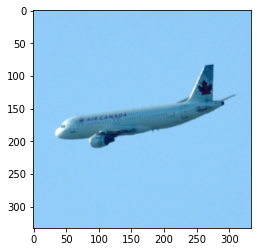

In [ ]:
def read_img(file):
    image_string = tf.io.read_file(file) 
    image_decode = tf.image.decode_image(image_string)

    return image_decode

img = read_img('drive/MyDrive/image/airplane.png')  
plt.imshow(img)

In [ ]:
image_string = tf.io.read_file('drive/MyDrive/image/airplane.png') 
image_decode = tf.image.decode_image(image_string)

In [ ]:
with summary_writer.as_default():  
    tf.summary.image("Airplane", [image_decode], step=0)

In [ ]:
!ls drive/MyDrive/image/

airplane_color.png  airplane.png      airplane_zoom.png
airplane_flip.png   airplane_rot.png  elephant.jpg


In [ ]:
img_files = ['airplane_zoom.png', 'airplane_flip.png', 'airplane_color.png', 'airplane_rot.png',
             'airplane.png']  

imgs = [] 

for file in img_files: 
    imgs.append(read_img('drive/MyDrive/image/'+file))  

with summary_writer.as_default():
    tf.summary.image("Airplane Augmentation", imgs, max_outputs=5, step=0) 

In [ ]:
with summary_writer.as_default():  
    for i, img in enumerate(imgs):
        tf.summary.image("Save image each step", [img], step=i)

In [ ]:
texts = ["小明：Cubee小助理最近好想學深度學習的技術哦!", 
         "Cubee：這是當然的阿，這可現今最火的技術呢!", 
         "小明：那我該如何入門呢?", 
         "Cubee：推薦你一本書「輕鬆學會Google TensorFlow2.0深度學習」。", 
         "小明：這本書沒有深度學習經驗的人也能學會嗎?", 
         "Cubee：這是當然的，你只需要基礎Python能力就可以學會了!", 
         "小明：太好了那我要趕快去買了!"]

with summary_writer.as_default():  
    for i, text in enumerate(texts):
        tf.summary.text("Chat record", text, step=i)

In [ ]:
def read_audio(file):
    audio_string = tf.io.read_file(file)  
    audio, fs = tf.audio.decode_wav(audio_string)

    audio = tf.expand_dims(audio, axis=0)
    return audio, fs

audio, fs = read_audio('drive/MyDrive/audio/cat.wav')  

with summary_writer.as_default(): 
    tf.summary.audio('cat', audio, fs, step=0)

In [ ]:
data = tf.random.normal([64, 100], dtype=tf.float64)

In [ ]:
with summary_writer.as_default():
    tf.summary.histogram('Normal distribution', data, step=0)

In [ ]:
with summary_writer.as_default():
    for i, offset in enumerate(tf.range(0, 10, delta=0.1, dtype=tf.float64)):
        tf.summary.histogram('Normal distribution 2', data+offset, step=i)

In [ ]:
import os
import io
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from preprocessing import parse_aug_fn, parse_fn

In [ ]:
y_true = [2, 1, 0, 2, 2, 0, 1, 1]
y_pred = [0, 1, 0, 2, 2, 0, 2, 1]
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=3).numpy()
print(cm)

[[2 0 0]
 [0 2 1]
 [1 0 2]]


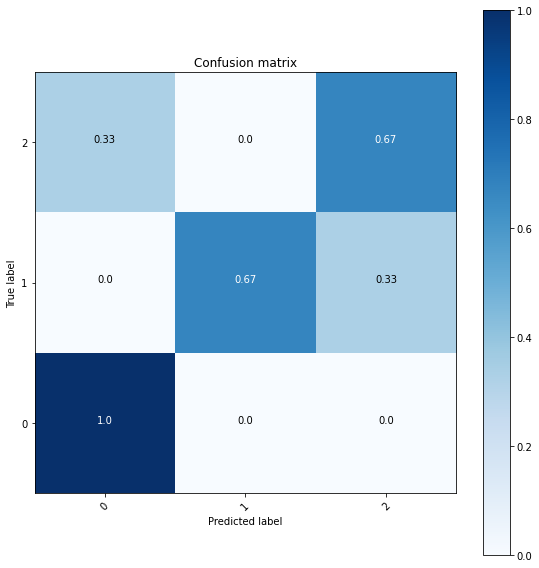

In [ ]:
def plot_confusion_matrix(cm, class_names):
  
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    tick_index = np.arange(len(class_names))
    plt.ylim([-0.5, 2.5])
    plt.yticks(tick_index, class_names)
    plt.xticks(tick_index, class_names, rotation=45)
    plt.colorbar()

    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
            
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return figure

img = plot_confusion_matrix(cm, [0, 1, 2])

In [ ]:
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

In [ ]:
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=3).numpy()
img = plot_confusion_matrix(cm, [0, 1, 2])
img_show = plot_to_image(img)

In [ ]:
class ConfusionMatrix(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, test_data, class_name):
        super(ConfusionMatrix, self).__init__()
        self.log_dir = log_dir
        self.test_data = test_data
        self.class_names = class_name
        self.num_classes = len(class_name)

    def on_train_begin(self, logs=None):
        path = os.path.join(self.log_dir, 'confusion_matrix')
        self.writer = tf.summary.create_file_writer(path)

    def on_epoch_end(self, epoch, logs=None):
        total_cm = np.zeros([10, 10])
        for x, y_true in self.test_data:
            y_pred = self.model.predict(x)
            y_pred = np.argmax(y_pred, axis=1)
            y_true = np.argmax(y_true, axis=1)
            cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes).numpy()
            total_cm += cm
        
        figure = plot_confusion_matrix(total_cm, class_names=self.class_names)
        cm_image = plot_to_image(figure)

        with self.writer.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [ ]:
train_split, valid_split = ['train[:90%]', 'train[90%:]']
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)
valid_data = tfds.load("cifar10", split=valid_split)
test_data = tfds.load("cifar10", split=tfds.Split.TEST)
class_name = info.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteLO30CA/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteLO30CA/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  
batch_size = 64  
train_num = int(info.splits['train'].num_examples / 10) * 9 

train_data = train_data.shuffle(train_num) 
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, 3, activation='relu', kernel_initializer='glorot_uniform')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(256, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(128, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(64, 3, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()

Model: "model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         295040    
                                                           

In [ ]:
logs_dirs = 'lab7-logs-images'
model_cbk = keras.callbacks.TensorBoard(logs_dirs)

save_cm = ConfusionMatrix(logs_dirs, test_data, class_name)

In [ ]:
model_1.compile(keras.optimizers.Adam(), 
                loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
                metrics=[keras.metrics.CategoricalAccuracy()])

In [ ]:
model_1.fit(train_data,
            epochs=100, 
            validation_data=valid_data,
            callbacks=[model_cbk, save_cm])

Epoch 1/100
704/704 [==============================] - 54s 48ms/step - loss: 2.0881 - categorical_accuracy: 0.2129 - val_loss: 1.8114 - val_categorical_accuracy: 0.3464
Epoch 2/100
704/704 [==============================] - 32s 45ms/step - loss: 1.8996 - categorical_accuracy: 0.2956 - val_loss: 1.5591 - val_categorical_accuracy: 0.4404
Epoch 3/100
704/704 [==============================] - 32s 45ms/step - loss: 1.7863 - categorical_accuracy: 0.3398 - val_loss: 1.4485 - val_categorical_accuracy: 0.4696
Epoch 4/100
704/704 [==============================] - 32s 45ms/step - loss: 1.6885 - categorical_accuracy: 0.3826 - val_loss: 1.3603 - val_categorical_accuracy: 0.5136
Epoch 5/100
704/704 [==============================] - 32s 45ms/step - loss: 1.6424 - categorical_accuracy: 0.4040 - val_loss: 1.3093 - val_categorical_accuracy: 0.5320
Epoch 6/100
704/704 [==============================] - 32s 45ms/step - loss: 1.5733 - categorical_accuracy: 0.4372 - val_loss: 1.2529 - val_categorical_acc

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

from preprocessing import parse_aug_fn, parse_fn

In [ ]:
from tensorboard.plugins.hparams import api as hp

In [ ]:
hparam_ia = hp.HParam('Imgae_Augmentation', hp.Discrete([False, True]))
hparam_bn = hp.HParam('Batch_Normalization', hp.Discrete([False, True]))
hparam_init = hp.HParam('Weight_Initialization', hp.Discrete(['RandomNormal_0.01std', 'glorot_normal', 'he_normal']))
hparam_lr = hp.HParam('Learning_Rate', hp.Discrete([0.001, 0.01, 0.03]))

In [ ]:
metric = 'Accuracy'
log_dirs = "lab7-logs-hparams/hparam_tuning"
with tf.summary.create_file_writer(log_dirs).as_default():
    hp.hparams_config(
        hparams=[hparam_ia, hparam_bn, hparam_init, hparam_lr],
        metrics=[hp.Metric(metric, display_name='Accuracy')],
    )

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  
batch_size = 64  
train_split, valid_split = ['train[:90%]', 'train[90%:]']

train_data_noaug, info = tfds.load("cifar10", split=train_split, with_info=True)
train_data_aug = tfds.load("cifar10", split=train_split)
valid_data = tfds.load("cifar10", split=valid_split)

train_num = int(info.splits['train'].num_examples / 5) * 4  

train_data_noaug = train_data_noaug.shuffle(train_num)  
train_data_noaug = train_data_noaug.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
train_data_noaug = train_data_noaug.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

train_data_aug = train_data_aug.shuffle(train_num)  
train_data_aug = train_data_aug.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data_aug = train_data_aug.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
class HyperparameterCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, hparams):
        super(HyperparameterCallback, self).__init__()
        self.log_dir = log_dir
        self.hparams = hparams
        self.best_accuracy = 0
        self.writer = None
        
    def on_train_begin(self, logs=None):
        self.writer = tf.summary.create_file_writer(self.log_dir)

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_categorical_accuracy')
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            
    def on_train_end(self, logs=None):
        with self.writer.as_default():
            hp.hparams(self.hparams)  # record the values used in this trial
            tf.summary.scalar(metric, self.best_accuracy, step=0)

In [ ]:
def train_test_model(logs_dir, hparams):

    if hparams[hparam_init] == "glorot_normal":
        init = keras.initializers.glorot_normal()
    elif hparams[hparam_init] == "he_normal":
        init = keras.initializers.he_normal()
    else:
        init = keras.initializers.RandomNormal(0, 0.01)

    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(64, (3, 3), kernel_initializer=init)(inputs)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, kernel_initializer=init)(x)
    if hparams[hparam_bn]: x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='model')
    model_tb = keras.callbacks.TensorBoard(log_dir=logs_dir, write_graph=False)
    model_mckp = keras.callbacks.ModelCheckpoint(logs_dir +'/best-model.hdf5', 
                                                 monitor='val_categorical_accuracy', 
                                                 save_best_only=True, 
                                                 mode='max')
    
    model_els = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy' , 
                                              min_delta=0, 
                                              patience=30, 
                                              mode='max')
    model_hparam = HyperparameterCallback(logs_dir + 'hparam_tuning', hparams)


    model.compile(keras.optimizers.Adam(hparams[hparam_lr]), 
                  loss=keras.losses.CategoricalCrossentropy(), 
                  metrics=[keras.metrics.CategoricalAccuracy()])
    
    if hparams[hparam_ia]:
        history = model.fit(train_data_aug,
                            epochs=2, 
                            validation_data=valid_data,
                            callbacks=[model_tb, model_mckp, model_els, model_hparam])
    else:
        history = model.fit(train_data_noaug,
                            epochs=2, 
                            validation_data=valid_data,
                            callbacks=[model_tb, model_mckp, model_els, model_hparam])

In [ ]:
session_id = 1 
for ia in hparam_ia.domain.values:
    for bn in hparam_bn.domain.values:
        for init in hparam_init.domain.values:
            for lr in hparam_lr.domain.values:        
                print('--- Running training session {}'.format(session_id))
                hparams = {hparam_ia: ia, hparam_bn: bn, hparam_init: init, hparam_lr: lr}
                logs_dir = os.path.join("lab7-logs-hparams", "run-{}".format(session_id))
                train_test_model(logs_dir, hparams)
                session_id += 1  # id+1

--- Running training session 1
Epoch 1/2
  5/704 [..............................] - ETA: 20s - loss: 2.3027 - categorical_accuracy: 0.1000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0137s vs `on_train_batch_end` time: 0.0148s). Check your callbacks.


704/704 [==============================] - 34s 32ms/step - loss: 2.3027 - categorical_accuracy: 0.0989 - val_loss: 2.3026 - val_categorical_accuracy: 0.1006
Epoch 2/2
704/704 [==============================] - 23s 32ms/step - loss: 2.3027 - categorical_accuracy: 0.0979 - val_loss: 2.3030 - val_categorical_accuracy: 0.0956
--- Running training session 2
Epoch 1/2
704/704 [==============================] - 24s 32ms/step - loss: 2.3161 - categorical_accuracy: 0.0997 - val_loss: 2.3033 - val_categorical_accuracy: 0.0994
Epoch 2/2
704/704 [==============================] - 22s 31ms/step - loss: 2.3035 - categorical_accuracy: 0.0988 - val_loss: 2.3047 - val_categorical_accuracy: 0.0994
--- Running training session 3
Epoch 1/2
704/704 [==============================] - 23s 32ms/step - loss: 4.3346 - categorical_accuracy: 0.0993 - val_loss: 2.3053 - val_categorical_accuracy: 0.0940
Epoch 2/2
704/704 [==============================] - 23s 32ms/step - loss: 2.3058 - categorical_accuracy: 0.0985 

704/704 [==============================] - 23s 32ms/step - loss: 36.1186 - categorical_accuracy: 0.0993 - val_loss: 2.3030 - val_categorical_accuracy: 0.1000
Epoch 2/2
704/704 [==============================] - 22s 31ms/step - loss: 2.3055 - categorical_accuracy: 0.1013 - val_loss: 2.3037 - val_categorical_accuracy: 0.0956
--- Running training session 7
Epoch 1/2
  5/704 [..............................] - ETA: 19s - loss: 2.5311 - categorical_accuracy: 0.0875WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0130s vs `on_train_batch_end` time: 0.0141s). Check your callbacks.


704/704 [==============================] - 22s 31ms/step - loss: 1.8098 - categorical_accuracy: 0.3258 - val_loss: 1.3903 - val_categorical_accuracy: 0.4890
Epoch 2/2
704/704 [==============================] - 22s 30ms/step - loss: 1.4515 - categorical_accuracy: 0.4720 - val_loss: 1.2429 - val_categorical_accuracy: 0.5450
--- Running training session 8
Epoch 1/2
  5/704 [..............................] - ETA: 20s - loss: 74.5712 - categorical_accuracy: 0.0844WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0137s vs `on_train_batch_end` time: 0.0138s). Check your callbacks.


704/704 [==============================] - 23s 32ms/step - loss: 2.8263 - categorical_accuracy: 0.0983 - val_loss: 2.3024 - val_categorical_accuracy: 0.1094
Epoch 2/2
704/704 [==============================] - 22s 30ms/step - loss: 2.3035 - categorical_accuracy: 0.1001 - val_loss: 2.3027 - val_categorical_accuracy: 0.0948
--- Running training session 9
Epoch 1/2
704/704 [==============================] - 23s 32ms/step - loss: 76.8956 - categorical_accuracy: 0.0990 - val_loss: 2.3053 - val_categorical_accuracy: 0.0956
Epoch 2/2
704/704 [==============================] - 22s 31ms/step - loss: 2.3055 - categorical_accuracy: 0.0981 - val_loss: 2.3039 - val_categorical_accuracy: 0.1006
--- Running training session 10
Epoch 1/2
704/704 [==============================] - 28s 37ms/step - loss: 1.6367 - categorical_accuracy: 0.4166 - val_loss: 1.5630 - val_categorical_accuracy: 0.4452
Epoch 2/2
704/704 [==============================] - 26s 37ms/step - loss: 1.1987 - categorical_accuracy: 0.581

704/704 [==============================] - 23s 31ms/step - loss: 2.5951 - categorical_accuracy: 0.0991 - val_loss: 2.3068 - val_categorical_accuracy: 0.0940
Epoch 2/2
704/704 [==============================] - 22s 31ms/step - loss: 2.3052 - categorical_accuracy: 0.1023 - val_loss: 2.3029 - val_categorical_accuracy: 0.1094
--- Running training session 22
Epoch 1/2
  5/704 [..............................] - ETA: 22s - loss: 2.3288 - categorical_accuracy: 0.1000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0158s). Check your callbacks.


704/704 [==============================] - 22s 30ms/step - loss: 2.0608 - categorical_accuracy: 0.2204 - val_loss: 1.8930 - val_categorical_accuracy: 0.3128
Epoch 2/2
704/704 [==============================] - 22s 31ms/step - loss: 1.8576 - categorical_accuracy: 0.3177 - val_loss: 1.5455 - val_categorical_accuracy: 0.4390
--- Running training session 23
Epoch 1/2
  5/704 [..............................] - ETA: 22s - loss: 70.6773 - categorical_accuracy: 0.1094 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0166s). Check your callbacks.


704/704 [==============================] - 23s 31ms/step - loss: 2.7917 - categorical_accuracy: 0.0980 - val_loss: 2.3026 - val_categorical_accuracy: 0.1006
Epoch 2/2
704/704 [==============================] - 22s 31ms/step - loss: 2.3038 - categorical_accuracy: 0.0988 - val_loss: 2.3025 - val_categorical_accuracy: 0.1094
--- Running training session 24
Epoch 1/2
704/704 [==============================] - 23s 31ms/step - loss: 121.3782 - categorical_accuracy: 0.0994 - val_loss: 2.3057 - val_categorical_accuracy: 0.0994
Epoch 2/2
704/704 [==============================] - 22s 31ms/step - loss: 2.3052 - categorical_accuracy: 0.1002 - val_loss: 2.3059 - val_categorical_accuracy: 0.1094
--- Running training session 25
Epoch 1/2
704/704 [==============================] - 23s 31ms/step - loss: 2.0392 - categorical_accuracy: 0.2359 - val_loss: 1.6786 - val_categorical_accuracy: 0.3576
Epoch 2/2
704/704 [==============================] - 22s 31ms/step - loss: 1.8155 - categorical_accuracy: 0.3

704/704 [==============================] - 23s 31ms/step - loss: 2.9414 - categorical_accuracy: 0.1012 - val_loss: 2.3031 - val_categorical_accuracy: 0.1000
Epoch 2/2
704/704 [==============================] - 21s 30ms/step - loss: 2.3036 - categorical_accuracy: 0.1001 - val_loss: 2.3045 - val_categorical_accuracy: 0.0948
--- Running training session 27
Epoch 1/2
  5/704 [..............................] - ETA: 24s - loss: 7225.7329 - categorical_accuracy: 0.1063 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0167s). Check your callbacks.


704/704 [==============================] - 23s 31ms/step - loss: 53.8413 - categorical_accuracy: 0.1009 - val_loss: 2.3050 - val_categorical_accuracy: 0.0984
Epoch 2/2
704/704 [==============================] - 21s 30ms/step - loss: 2.3053 - categorical_accuracy: 0.1008 - val_loss: 2.3076 - val_categorical_accuracy: 0.0984
--- Running training session 28
Epoch 1/2
704/704 [==============================] - 27s 36ms/step - loss: 1.9210 - categorical_accuracy: 0.3112 - val_loss: 1.6371 - val_categorical_accuracy: 0.4126
Epoch 2/2
704/704 [==============================] - 25s 36ms/step - loss: 1.6121 - categorical_accuracy: 0.4219 - val_loss: 1.3795 - val_categorical_accuracy: 0.5114
--- Running training session 29
Epoch 1/2
704/704 [==============================] - 27s 36ms/step - loss: 1.9174 - categorical_accuracy: 0.2938 - val_loss: 2.0068 - val_categorical_accuracy: 0.2786
Epoch 2/2
704/704 [==============================] - 26s 36ms/step - loss: 1.6881 - categorical_accuracy: 0.38